# Representational similarity analysis: Whole-brain searchlight
Natalia Vélez, May 2022

In [1]:
%matplotlib inline

## uncomment for scripting
# import matplotlib
# matplotlib.use('Agg')

# general utils
import os,sys,pickle
import numpy as np
import pandas as pd
from os.path import join as opj
from scipy.io import loadmat
from sklearn.metrics import pairwise_distances
from scipy.spatial import distance
from ast import literal_eval

# plottting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

# fmri-specific modules
from nilearn import image, masking, plotting
import rsatoolbox as rsa
from rsatoolbox.util import searchlight

# project-specific modules
sys.path.append('..')
from utils import gsearch, print_list, int_extract, str_extract, upper_tri

sys.path.append('../2_behavioral')
from teaching_models import human_df as teach_df

Loading teaching problems
{'A': [[0, 0, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 0],
       [0, 0, 1, 1, 0, 0]],
 'B': [[1, 1, 1, 0, 0, 0],
       [1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]],
 'C': [[0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1],
       [0, 0, 1, 1, 1, 1],
       [0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]],
 'D': [[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1]]}
Participants excluded from analysis:
[3, 17]
Cleaning up human behavioral data
    subject  run  block_idx  ex_idx first_movement   start  problem  \
0         1    1          0       0         [0, 1]  [0, 0]       22   
1         1    1          0       1         [0, 1]  [0, 0]       22   
3         1    1          1   

Preparing RDMs for subject: sub-01
Saving results to: outputs/searchlight_rsa/sub-01
Found 10 event files
../../BIDS_data/derivatives/model_events/sub-01/func/sub-01_task-teaching_run-01_model-main_events.tsv
../../BIDS_data/derivatives/model_events/sub-01/func/sub-01_task-teaching_run-02_model-main_events.tsv
../../BIDS_data/derivatives/model_events/sub-01/func/sub-01_task-teaching_run-03_model-main_events.tsv
../../BIDS_data/derivatives/model_events/sub-01/func/sub-01_task-teaching_run-04_model-main_events.tsv
../../BIDS_data/derivatives/model_events/sub-01/func/sub-01_task-teaching_run-05_model-main_events.tsv
../../BIDS_data/derivatives/model_events/sub-01/func/sub-01_task-teaching_run-06_model-main_events.tsv
../../BIDS_data/derivatives/model_events/sub-01/func/sub-01_task-teaching_run-07_model-main_events.tsv
../../BIDS_data/derivatives/model_events/sub-01/func/sub-01_task-teaching_run-08_model-main_events.tsv
../../BIDS_data/derivatives/model_events/sub-01/func/sub-01_task-teach

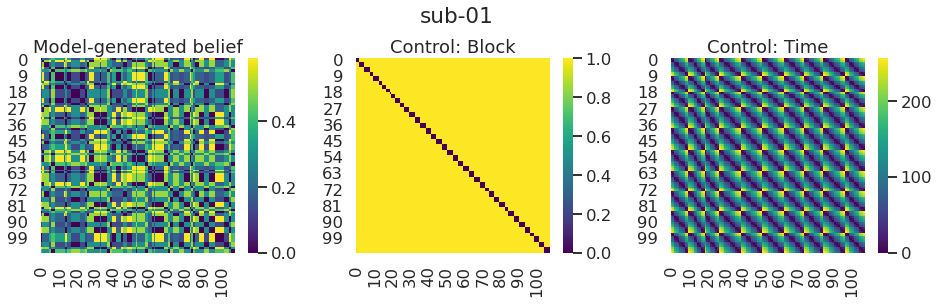

In [2]:
# _, sub_no = sys.argv # uncomment for scripting
sub_no = '1'
sub_no = int(sub_no)
subject = f'sub-{sub_no:02}'
print(f'Preparing RDMs for subject: {subject}')

# Make output directory:
out_dir = opj(f'outputs/searchlight_rsa/{subject}')
print(f'Saving results to: {out_dir}')
os.makedirs(out_dir, exist_ok=True)

# Find event files:
data_dir = '../../BIDS_data/derivatives/'
event_files = gsearch(data_dir, 'model_events', subject, 'func', '*model-main*')
event_files.sort()
print_list(event_files, 'event files')

# Find ROI files:
roi_files = gsearch(data_dir, 'roi_picker', subject, 'func', '*mask.nii.gz')
roi_files.sort()
print_list(roi_files, 'mentalizing ROIs')

# Find beta directory:
beta_dir = opj(data_dir, 'glm', subject, 'func', 'task-teaching_model-beta')
print(f'\nLoading betas from:\n{beta_dir}')

# ## Choose beta images to include in analysis
# Find input files
print('\nLabeling beta images')
SPM = loadmat(opj(beta_dir, 'SPM.mat'))
beta_labels = [r[0] for r in SPM['SPM']['xX'][0][0][0][0]['name'][0]]

# assemble dataframe of labels
beta_df = pd.DataFrame({'label': beta_labels})
beta_df['beta_no'] = beta_df.index+1
beta_df['beta'] = beta_df.beta_no.apply(lambda b: opj(beta_dir, f'beta_{b:0004}.nii'))
beta_df = (
    beta_df
    [beta_df.label.str.contains('show_')]
    .drop(columns='beta_no')
)
beta_df['run'] = beta_df.label.apply(lambda s: int_extract('(?<=run-)[0-9]+', s))
beta_df['trial'] = beta_df.label.apply(lambda s: int_extract('(?<=trial-)[0-9]+', s))
beta_df = beta_df.sort_values(['run', 'trial']).reset_index(drop=True)

print(beta_df.shape)
print(beta_df.head())

print('\nFiltering out observations where participant failed to provide a hint')
show_list = []
for f in event_files:
    f_df = pd.read_csv(f, sep='\t')
    show_events = (
        f_df
       [f_df.trial_type.str.contains('show')]
       .copy()
       .reset_index(drop=True)
    )
    show_events['run'] = int_extract('(?<=run-)[0-9]+', f)
    show_events['trial'] = show_events.index+1
    show_events['include'] = show_events.trial_type.str.contains('new$')
    show_events = show_events[['run', 'trial', 'onset', 'include']]
    show_list.append(show_events)
    
events_df = pd.concat(show_list) # put everything together
print(events_df.shape)
print(events_df.head())

print('\nPutting everything together')
in_df = beta_df.merge(events_df)
in_df = (
    in_df
    [in_df.include]
    .drop(columns=['include'])
    .reset_index(drop=True)
)
print(in_df.shape)
print(in_df.head())


behav_events = teach_df[teach_df.subject == sub_no].copy()
behav_events['trial'] = behav_events['block_idx']*3+behav_events['ex_idx']+1
behav_events = behav_events[['run', 'trial']]
behav_events = behav_events.merge(in_df, how='left')

behav_events.shape
behav_events.head()


# ## Define behavioral RDMS

# Model-based RDM
print('\n==== RDM 1: Model-predicted beliefs ====')
print('Reading model predictions')
model_df = pd.read_csv('../2_behavioral/outputs/model_regressor_values.csv')
model_df = model_df[model_df.subject == sub_no].reset_index(drop=True)
model_df['pH'] = model_df.pH.apply(literal_eval).apply(np.array) # clean up belief distribution
print(model_df.shape)
print(model_df.head())

print('Computing RDM')
n_obs = model_df.shape[0]
model_dist = np.zeros((n_obs, n_obs))

for i, row_i in model_df.iterrows():
    for j, row_j in model_df.iterrows():
        model_dist[i,j] = distance.cosine(row_i.pH, row_j.pH)

# same mtx as model object
belief_model = rsa.model.ModelFixed('Model-predicted Beliefs', upper_tri(model_dist))
print(model_dist.shape)
print(belief_model)


# Control RDMs
print('Marking blocks/trials in event data')
n_frames = 152
tr = 2.0

time_df = events_df.copy()
time_df['block'] = np.floor((time_df.trial-1)/3).astype(int)
time_df['ex_idx'] = np.mod((time_df.trial-1), 3)
time_df = in_df.merge(time_df, how='left')
time_df = time_df[['run', 'trial', 'block', 'ex_idx', 'onset']]

print(time_df.shape)
print(time_df.head(15))

print('\n==== Control 1: Block RDM ====')
n_obs = time_df.shape[0]
block_dist = np.zeros((n_obs, n_obs))

for i, row_i in time_df.iterrows():
    for j, row_j in time_df.iterrows():
        same_block = (row_i.run == row_j.run) & (row_i.block == row_j.block)
        block_dist[i,j] = 1-same_block

# same mtx as model object
block_model = rsa.model.ModelFixed('Control: Block', upper_tri(block_dist))
print(block_dist.shape)
print(block_model)

print('\n==== Control 2: Time RDM ====')
# compute pairwise distances
ons = time_df.onset.values
ons_2d = np.expand_dims(ons, 1)
time_dist = pairwise_distances(ons_2d, metric=lambda t1,t2: np.abs(t1-t2))

# save mtx as model object
time_model = rsa.model.ModelFixed('Control: Time', upper_tri(time_dist))
print(time_dist.shape)
print(time_model)


# Plot all behavioral RDMs together
# plot RDM
fig,axes=plt.subplots(1,3, figsize=(16,4))

sns.heatmap(model_dist, cmap='viridis', square=True, ax=axes[0])
axes[0].set(title='Model-generated belief')

sns.heatmap(block_dist, cmap='viridis', square=True, ax=axes[1])
axes[1].set(title='Control: Block')

sns.heatmap(time_dist, cmap='viridis', square=True, ax=axes[2])
axes[2].set(title='Control: Time')

fig.suptitle(subject)
fig.subplots_adjust(top=0.8)

plt.savefig(opj(out_dir, f'{subject}_behavioral_RDM.png'))

# Save behavioral RDMs to file
behav_rdms = {'belief': belief_model, 'time': time_model, 'block': block_model}
with open(opj(out_dir, f'{subject}_behavioral_RDM.p'), 'wb') as f:
    pickle.dump(behav_rdms, f)

# ## Define neuro RDM
# Load beta images:
print('Loading beta images')
beta_img = image.load_img(in_df.beta.values)
print(beta_img.shape)

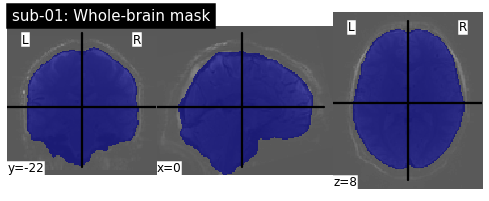

In [8]:
# Load whole-brain mask
mask_query = gsearch(data_dir, 'fmriprep', subject, 'func', f'{subject}*brain_mask.nii.gz')
mask_file = mask_query[0]
ref_file = mask_file.replace('desc-brain_mask', 'desc-preproc_bold')

mask = image.load_img(mask_query[0])
mask_data = mask.get_fdata()
ref_img = image.mean_img(ref_file)

# Plot and save to file
plotting.plot_roi(mask, title=f'{subject}: Whole-brain mask', bg_img=ref_img, black_bg=False)
plt.savefig(opj(out_dir, f'{subject}_mask_coverage.png'))

In [ ]:
# Get searchlight centers and neighbors
centers, neighbors = searchlight.get_volume_searchlight(mask_data, radius=5, threshold=0.5)

Finding searchlights...: 100%|██████████| 411553/411553 [01:58<00:00, 3472.74it/s]


Found 405744 searchlights


In [1]:
# reshape data so we have n_observastions x n_voxels
data = beta_img.get_fdata()
data_2d = data.reshape([data.shape[0], -1])
data_2d = np.nan_to_num(data_2d)

# only one pattern per image
image_value = np.arange(beta_img.shape[0])

# Get searchlight RDMs
data_RDM = get_searchlight_RDMs(data_2d, centers, neighbors, image_value, method='correlation')

NameError: name 'beta_img' is not defined

In [ ]:
print('\nComparing RDMs to neural data')
res = rsa.inference.evaluate.eval_fixed([belief_model, block_model, time_model], data_RDM, method='cosine')
print(res.evaluations)

print('\nSaving results to file')
data_RDM.save(opj(out_dir, f'{subject}_searchlight_RDM.h5'), overwrite=True)
res.save(opj(out_dir, f'{subject}_searchlight_model_comparison.h5'), overwrite=True)